# Phishing Link Predction with Machine Learing

## Necessary imports

**Run this command to install all nescessary packages**

*pip install pandas matplotlib wordcloud tld seaborn pandas scikit-learn*

In [44]:
import pandas as pd
import re
from urllib.parse import urlparse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tld import get_tld
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier

# Preprocessing and Data Frame Generation for Malicious URLs Dataset

## Load Dataset

In [2]:
#Read the dataset
df = pd.read_csv("malicious_phish.csv")

In [3]:
# Display dataset shape and first few records
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
# Display value counts for 'type'
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## Plotting Wordclouds

In [5]:
# Function to create word clouds for each type
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(
        width=1600, 
        height=800, 
        colormap='Paired'
    ).generate(text_data)
    
    plt.figure(figsize=(12, 14), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=24, color='white')
    plt.tight_layout(pad=0)
    plt.show()

In [6]:
# Split dataset by type
df_phishing = df[df['type'] == 'phishing']
df_malware = df[df['type'] == 'malware']
df_defacement = df[df['type'] == 'defacement']
df_benign = df[df['type'] == 'benign']

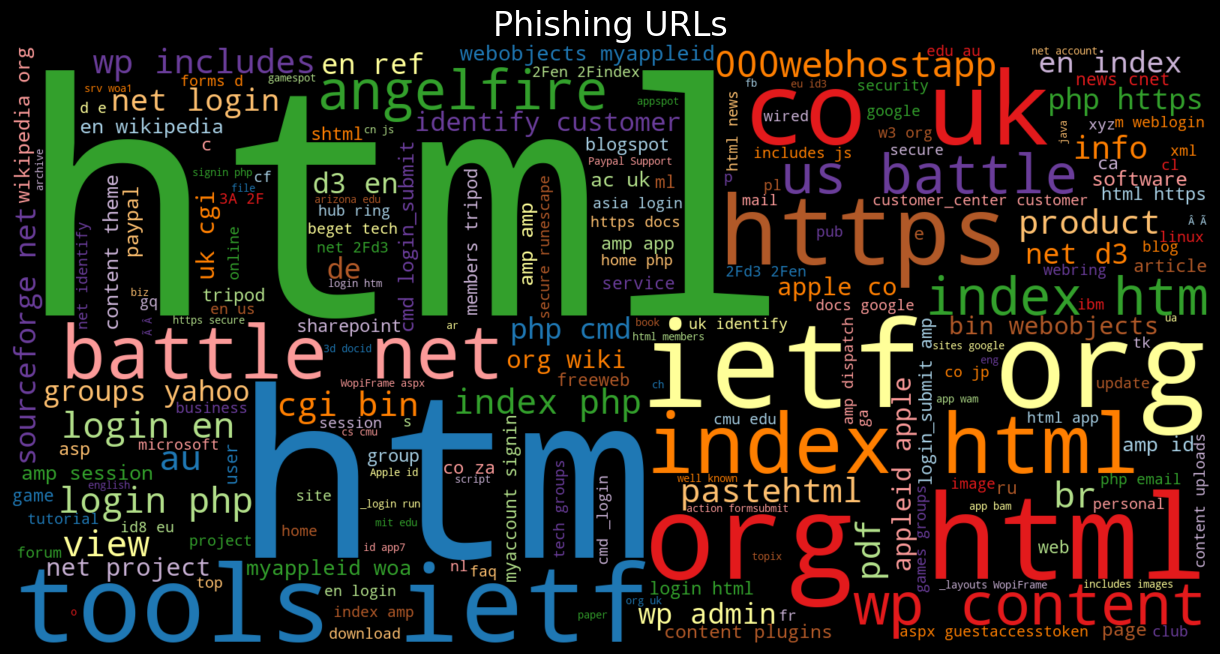

In [7]:
# Generate word clouds for each PHISHING type
generate_wordcloud(" ".join(df_phishing['url']), "Phishing URLs")

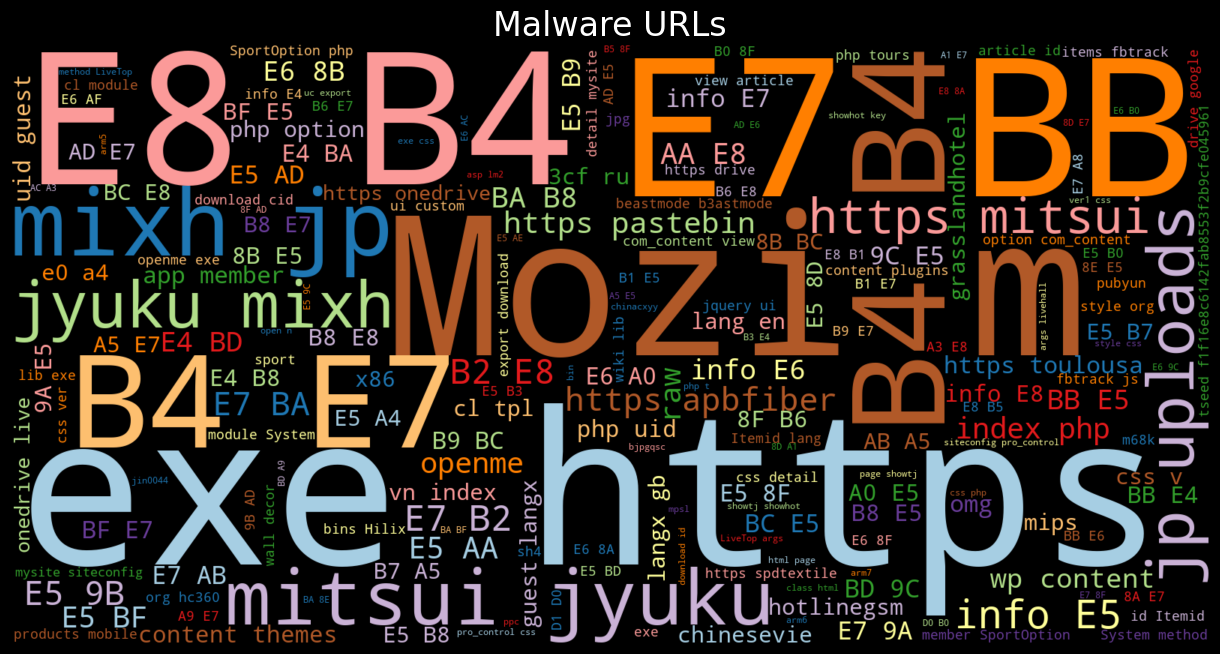

In [8]:
# Generate word clouds for MALWARE URL type
generate_wordcloud(" ".join(df_malware['url']), "Malware URLs")

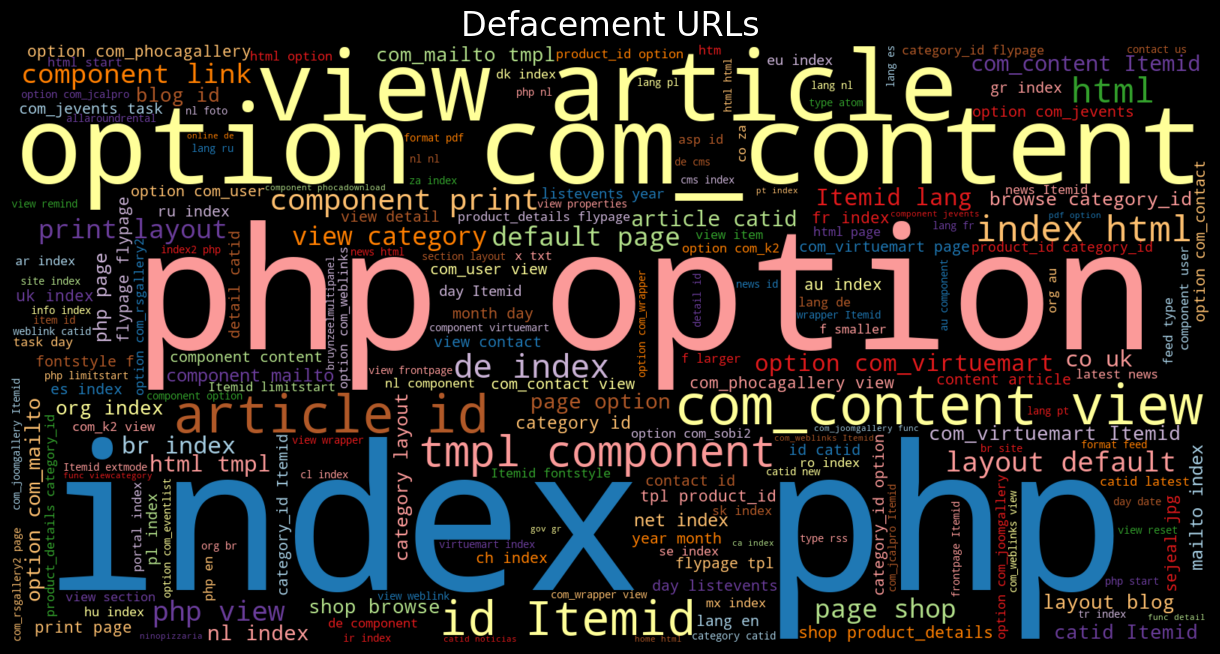

In [9]:
# Generate word clouds for each DEFACEMENT type
generate_wordcloud(" ".join(df_defacement['url']), "Defacement URLs")

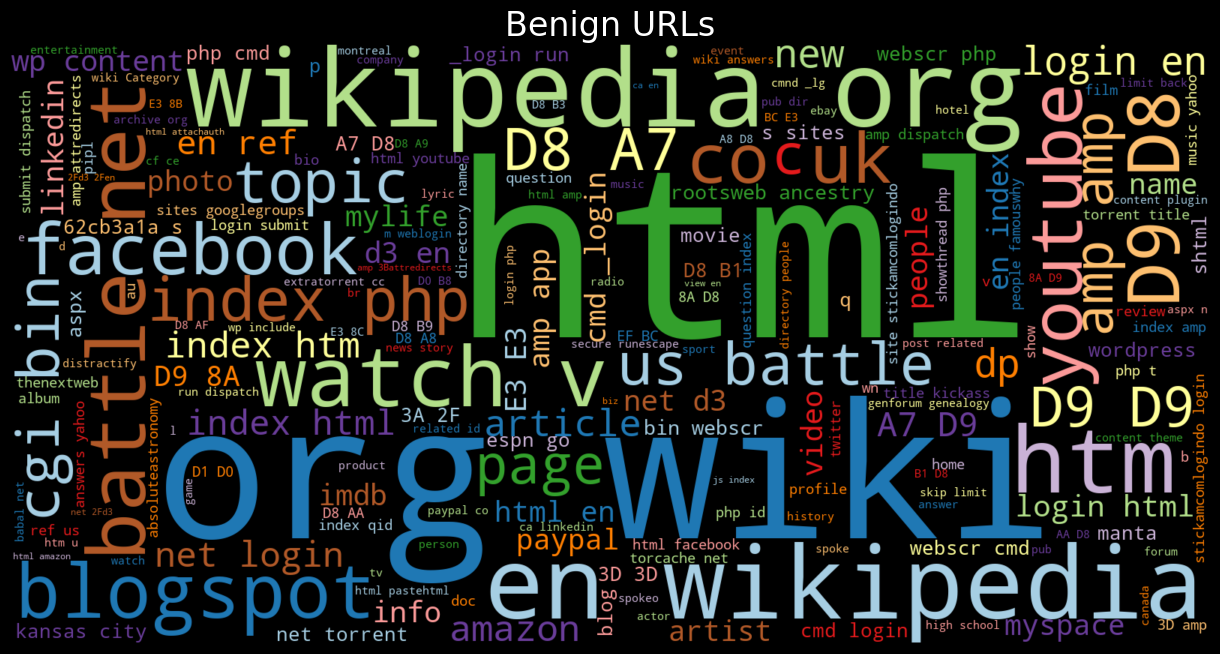

In [10]:
# Generate word clouds for each BENIGN type
generate_wordcloud(" ".join(df_benign['url']), "Benign URLs")

## Feature Selection Engineering

In [11]:
# Check if URL contains an IP address
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [12]:
# Check if URL is abnormal
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [13]:
# Check if URL has shortening service
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net', url)
    return 1 if match else 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [14]:
# Count occurrences of a character in a URL
def count_dot(url):
    count_dot = url.count('.')
    return count_dot
df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):
    url.count('www')
    return url.count('www')
df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')
df['count@'] = df['url'].apply(lambda i: count_atrate(i))

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))


def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

def count_http(url):
    return url.count('http')
df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_https(url):
    return url.count('https')
df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_per(url):
    return url.count('%')
df['count%'] = df['url'].apply(lambda i : count_per(i))


def count_ques(url):
    return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')
df['count='] = df['url'].apply(lambda i: count_equal(i))

In [15]:
# Calculate URL length and hostname length
def url_length(url):
    return len(str(url))
#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))

def hostname_length(url):
    return len(urlparse(url).netloc)
df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

In [16]:
# Check for suspicious words in URL
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [17]:
# Count the number of digits and letters in URL

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [18]:
# Calculate the length of the first directory in the URL
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

In [19]:
# Calculate the length of the top-level domain (TLD)
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [20]:
# Display final columns and value counts
df.columns
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

## Saving the Preprocessed Dataset

In [21]:
# Save the final DataFrame to a CSV file
df.to_csv('processed_urls.csv', index=False)

# Exploratory Data Analysis

## Read the Dataset

In [22]:
#Read the dataset
df_urls = pd.read_csv("processed_urls.csv", low_memory=False)

In [23]:
# Display dataset shape and first few records
print(df_urls.shape)
df_urls.head()

(651191, 24)


,url,type,use_of_ip,abnormal_url,short_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,0,2,0,0,0,0,...,1,0,16,0,0,0,13,0,NaN,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,2,0,...,0,0,35,0,0,1,29,5,NaN,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,3,0,...,0,0,31,0,0,1,25,7,NaN,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,0,3,1,0,1,0,...,1,4,88,21,0,7,63,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,0,2,0,0,1,0,...,1,3,235,23,0,22,199,9,net,3


## EDA

In [24]:
# Set the style for seaborn plots
sns.set(style="darkgrid")

### Distribution of IP address use:

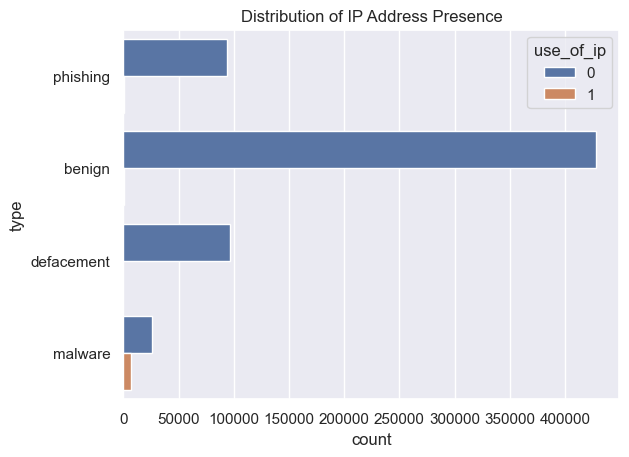

In [25]:
# Distribution of `use_of_ip`
ax = sns.countplot(y="type", data=df_urls, hue="use_of_ip")
plt.title('Distribution of IP Address Presence')
plt.show()

### Distribution of abnormal URLs:

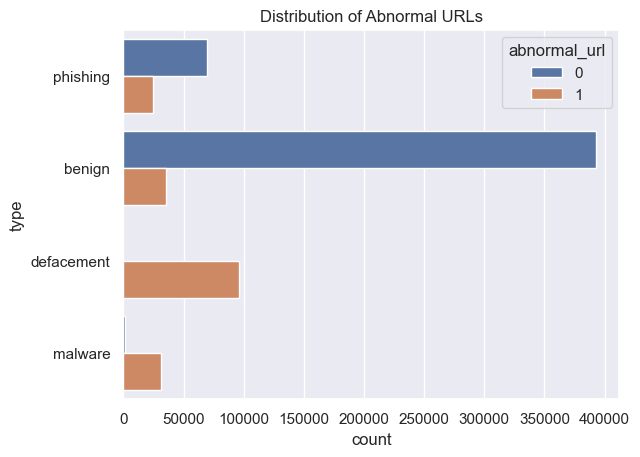

In [26]:
# Distribution of `abnormal_url`
ax = sns.countplot(y="type", data=df_urls, hue="abnormal_url")
plt.title('Distribution of Abnormal URLs')
plt.show()

### Distribution of Short URL:

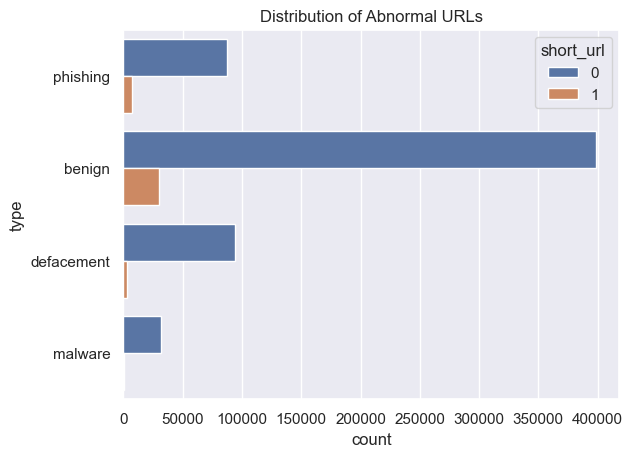

In [27]:
# Distribution of `abnormal_url`
ax = sns.countplot(y="type", data=df_urls, hue="short_url")
plt.title('Distribution of Abnormal URLs')
plt.show()

### Distribution of Suspicious URL:

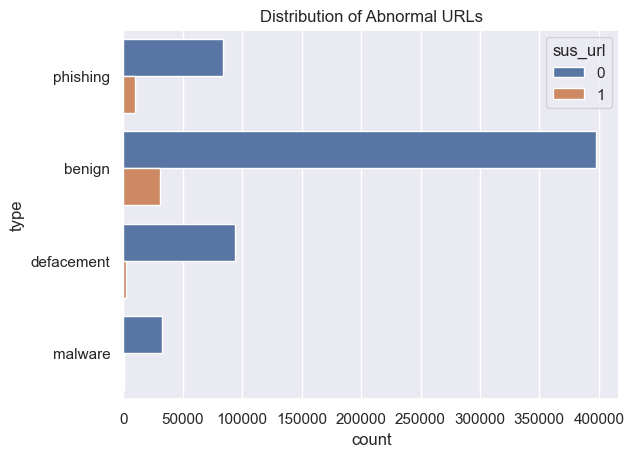

In [28]:
# Distribution of `has_suspicious_words`
ax = sns.countplot(y="type", data=df_urls, hue="sus_url")
plt.title('Distribution of Abnormal URLs')
plt.show()

### Distribution of Count of . (dot):

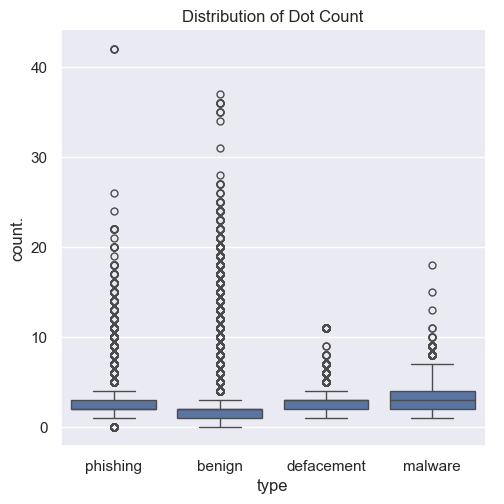

In [29]:
# Distribution of `dot_count`
ax = sns.catplot(x="type", y="count.", kind="box", data=df_urls)
plt.title('Distribution of Dot Count')
plt.show()

### Distribution of Count of www:

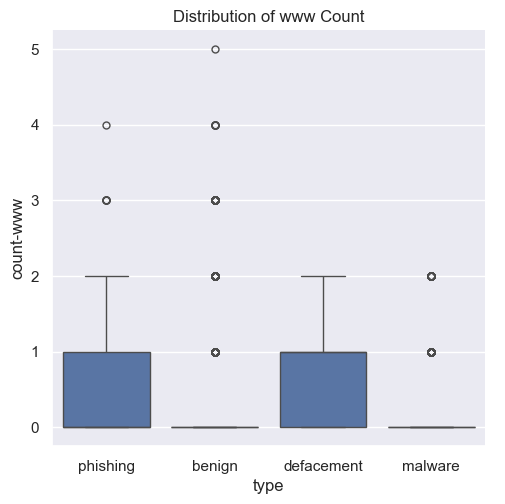

In [30]:
# Distribution of `www_count`
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df_urls)
plt.title('Distribution of www Count')
plt.show()

### Distribution of Count of @:

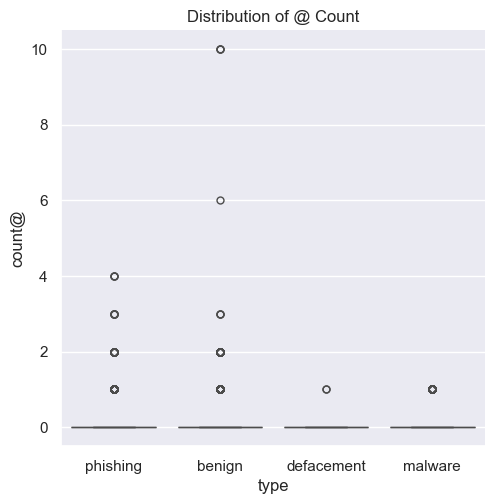

In [31]:
# Distribution of `at_sign_count`
ax = sns.catplot(x="type", y="count@", kind="box", data=df_urls)
plt.title('Distribution of @ Count')
plt.show()

### Distribution of Count of Directories:

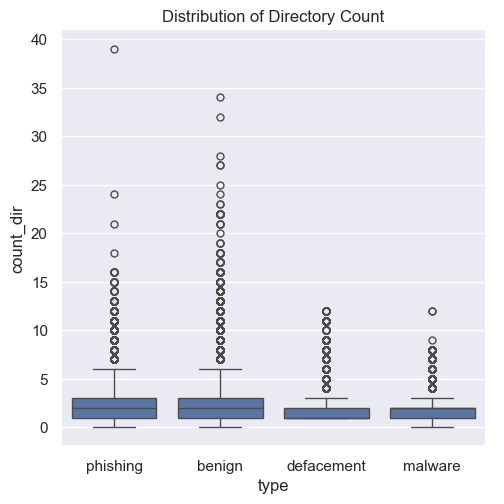

In [32]:
# Distribution of `dir_count`
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df_urls)
plt.title('Distribution of Directory Count')
plt.show()

### Distribution of Hostname Length:

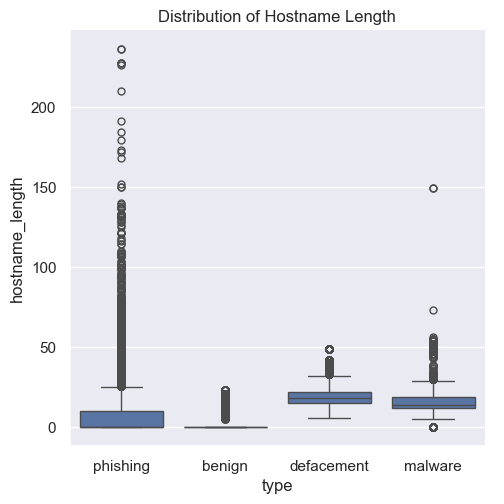

In [33]:
# Distribution of `hostname_length`
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df_urls)
plt.title('Distribution of Hostname Length')
plt.show()

### Distribution of First Directory Length:

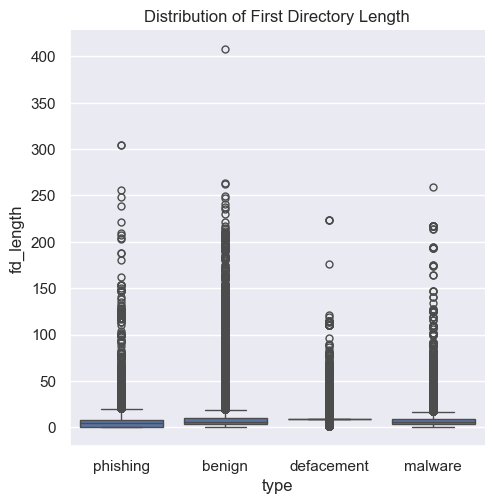

In [34]:
# Distribution of `first_dir_length`
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df_urls)
plt.title('Distribution of First Directory Length')
plt.show()

### Distribution of Top-Level Domain Length:

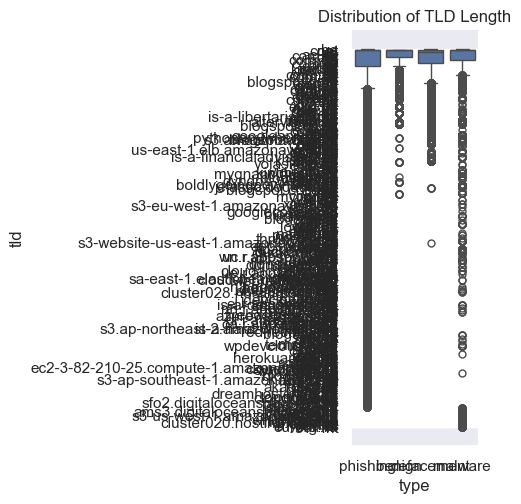

In [35]:
# Distribution of `tld_length`
ax = sns.catplot(x="type", y="tld", kind="box", data=df_urls)
plt.title('Distribution of TLD Length')
plt.show()

# Model Building

## Read the Dataset

In [36]:
#Read the dataset
df = pd.read_csv("processed_urls.csv", low_memory=False)

In [37]:
# Display dataset shape and first few records
print(df.shape)
df.head()

(651191, 24)


,url,type,use_of_ip,abnormal_url,short_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,0,2,0,0,0,0,...,1,0,16,0,0,0,13,0,NaN,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,2,0,...,0,0,35,0,0,1,29,5,NaN,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,3,0,...,0,0,31,0,0,1,25,7,NaN,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,0,3,1,0,1,0,...,1,4,88,21,0,7,63,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,0,2,0,0,1,0,...,1,3,235,23,0,22,199,9,net,3


## Creating Test and Train Data

In [38]:
# Encode target variable
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
print(df['type_code'].value_counts())

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64


In [39]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [40]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [41]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [42]:
# Spliting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

## Model Building

### Random Forest Classifier

In [45]:
# Adjusting RandomForest parameters
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    max_features=0.5,
    min_samples_split=50,
    random_state=42
)

rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.93      0.97      0.95     85621
  defacement       0.78      0.93      0.85     19292
    phishing       0.68      0.66      0.67      6504
     malware       0.86      0.53      0.66     18822

    accuracy                           0.89    130239
   macro avg       0.81      0.77      0.78    130239
weighted avg       0.89      0.89      0.88    130239

accuracy:   0.888


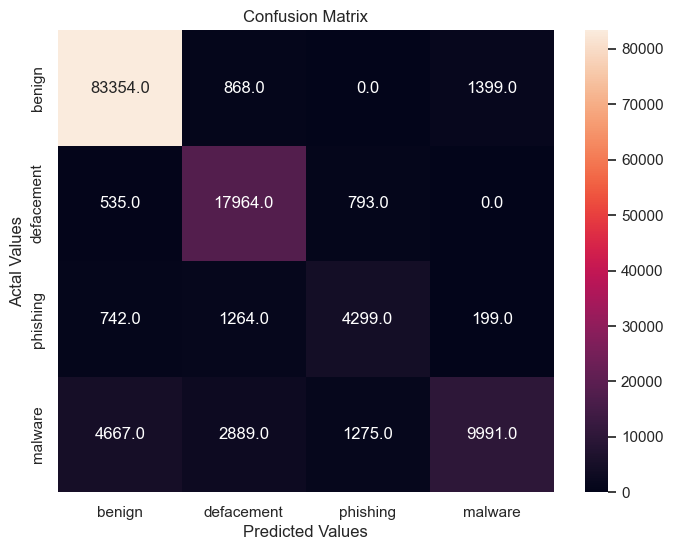

In [46]:
# Generating Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

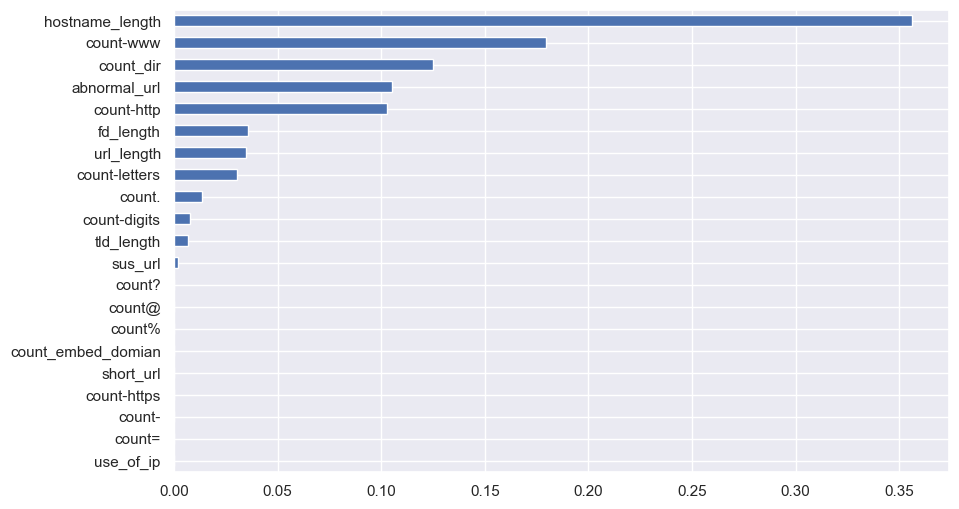

In [47]:
# Determining the features that are important for Random Forrest Classification
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

### XgBoost Classifier

In [48]:
# Adjusting XGBoost parameters
xgb_c = xgb.XGBClassifier(n_estimators= 100)

xgb_c = xgb.XGBClassifier(
    n_estimators=10,        
    learning_rate=0.3,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,  
    random_state=42
)

xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85621
  defacement       0.83      0.96      0.89     19292
    phishing       0.87      0.70      0.77      6504
     malware       0.88      0.62      0.73     18822

    accuracy                           0.91    130239
   macro avg       0.88      0.82      0.84    130239
weighted avg       0.91      0.91      0.91    130239

accuracy:   0.913


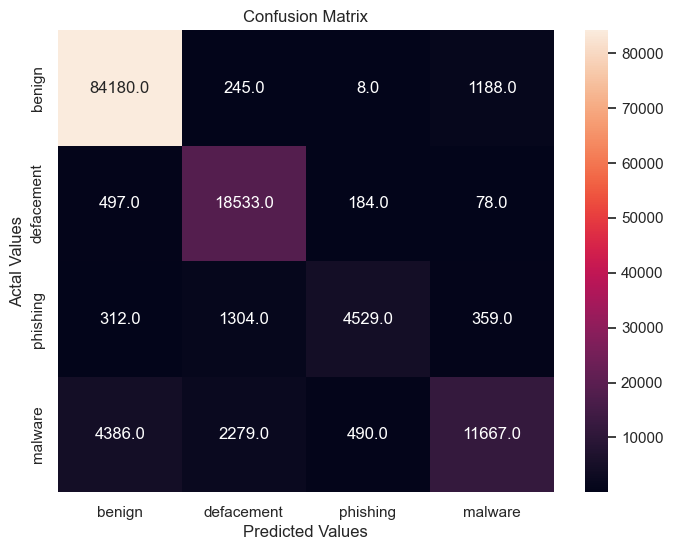

In [49]:
# Generating Confusion Matrix
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

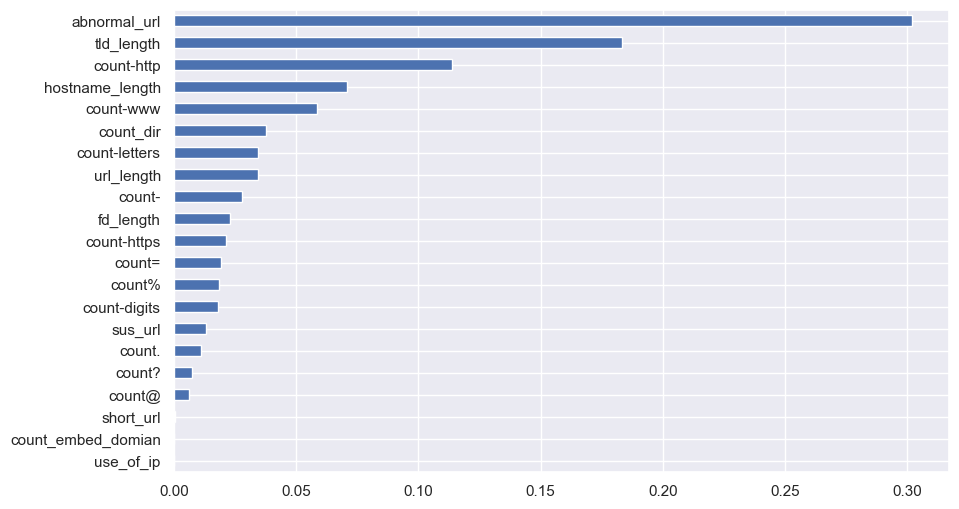

In [50]:
# Determining the features that are important for XGboost Classification
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

### Light GBM Classifier

In [51]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)
y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy     

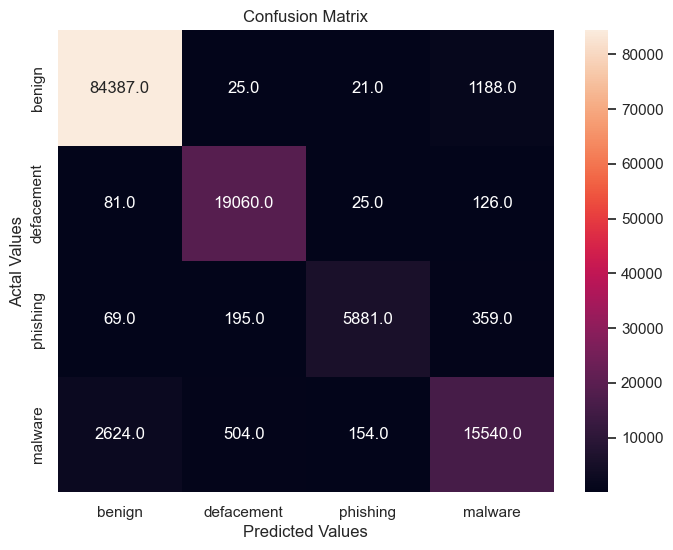

In [52]:
# Generating Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

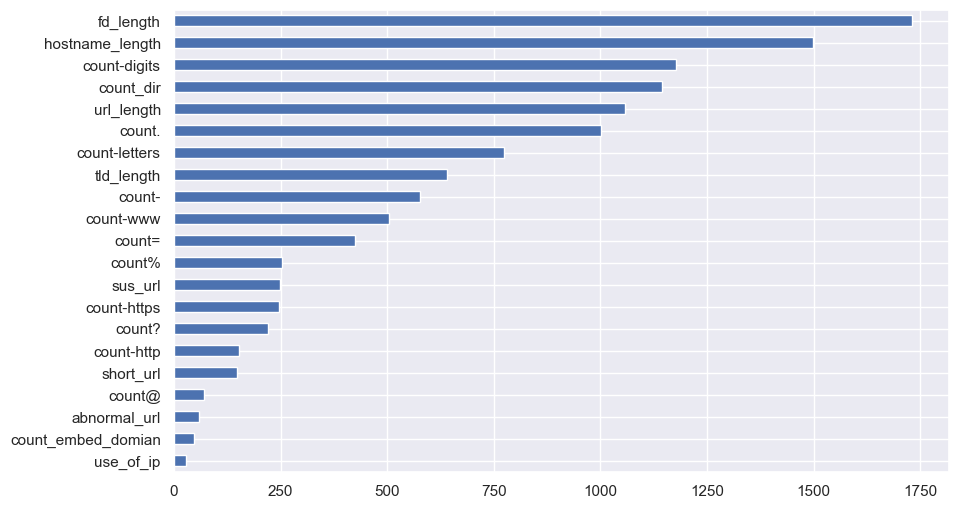

In [53]:
# Determining the features that are important for Light GBM Classification
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## Prediction

Using **Light GBM** for prediction as it is the most accurate.

In [54]:
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status

In [55]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))
    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

In [56]:
urls = ['titaniumcorporate.co.za','en.wikipedia.org/wiki/North_Dakota','google.com/hkjfk', '']

for url in urls:
     print(get_prediction_from_url(url))

[LightGBM] [Warning] Unknown parameter: silent
MALWARE
[LightGBM] [Warning] Unknown parameter: silent
SAFE
[LightGBM] [Warning] Unknown parameter: silent
SAFE
